# Requirements

## Hardware
- Tested on debian-like machine (pop-os to be exact), but ubuntu probably works

## Software
- Tested with g++ --version=10.3.0
```
sudo apt-get install g++ // or
sudo apt-get build-essential
```
-  Install **openMP**
```
sudo apt-get install libomp-dev
```
**openMP** is a library that offers support for seamless parallelization through thread launching. As the programmer, you only need to identify parts of your code feeble for parallelization, while the library itself is an abstractions that helps with loop indexing, thread launching, built-in locks, and is portable on different os, making it a nice option for users who don't care about hardware optimations for every different machine. 

For the graphing tools we will need python3 and matplotlib
```
sudo apt-get install python
# In this repository
python3 -m venv venv
source venv/bin/activate
pip install matplotlib
```


# Description

Follow this [youtube link from Geometry Lab](https://www.youtube.com/watch?v=NDGpsfwAaqo&t=705s&ab_channel=GeometryLab) for a more detailed explanation of a skiplist. Here is a summary of the properties of skiplist.

| Insertion | Deletion | Search |
| --------- | -------- | ------ |
| log(n)    | log(n)   | log(n) |

\*expected time

The skiplist is able to achieve these marks because it uses layers/levels of linked list (visually) stacked on top of each other for *skipping* sections of a normal linked list (which has linear time search), and thus tries to emulate the methodology behind *binary search*.


In the next few sections, I analyze 4 different skiplist implementations: [sequential](https://github.com/bustin11/parallel-skiplist/tree/sequential), [coarse-grain](https://github.com/bustin11/parallel-skiplist/tree/coarse-grain), [fine-grain](https://github.com/bustin11/parallel-skiplist/tree/fine-grain), and [lock-free](https://github.com/bustin11/parallel-skiplist/tree/lock-free). If want to run yourself, make sure you follow the Software guidelines and pull all 4 branches.

## Grab Metrics

In [7]:

def run(branch_name):
    !git checkout $branch_name
    !./run.sh
    !make clean

branch_names = ["sequential", "coarse-grain", "fine-grain", "lock-free"]

In [8]:
!git stash 

!rm output.txt
for name in branch_names:
    !echo $name >> output.txt
    run(name)

No local changes to save
rm: cannot remove 'output.txt': No such file or directory
Switched to branch 'sequential'
Your branch is up to date with 'origin/sequential'.
+ set -e
+ make clean
/bin/rm -rf *~ tests/test src/main  \
tests/*.o src/*.o
+ '[' '' '!=' main ']'
+ make test
g++ -m64 -std=c++20 tests/checker.cpp -Wall -Wno-unknown-pragmas -g -c -o tests/checker.o
g++ -m64 -std=c++20 tests/test.cpp -Wall -Wno-unknown-pragmas -g -c -o tests/test.o
g++ -m64 -std=c++20 skiplist.cpp -Wall -Wno-unknown-pragmas -g -c -o tests/skiplist.o
g++ -m64 -std=c++20 -Wall -Wno-unknown-pragmas -o tests/test tests/checker.o tests/test.o -g tests/skiplist.o
+ echo '
===== Testing for correctness... =====
'

===== Testing for correctness... =====

+ /home/justinhsu/parallel-skiplist/tests/test
Number of threads:1
Test 1[Simple]: 
11
Test 2[1 insertions at front]: 
  11
5 11
Test 3[1 insertions at back]: 
  11
  11
5 11
Test 4[1 insertions in the middle]: 
2 5 11
2 5 11
Test 5[25 insertions insertions]:

## Analysis

### Python Libraries

In [9]:
%pip install matplotlib
%pip install numpy 
%pip install pandas 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data conversion

In [4]:
def convert_to_csv():

    import re
    anyDigit = '([0-9]+\.?[0-9]*|\.[0-9]+)'
    filename = ''
    with open('output.txt') as f:
        threads = 0
        for line in f:

            # 2) check for threads argument
            matchthread = re.match(f'threads=([0-9]+)', line)
            if matchthread:
                threads = matchthread.group(1)
                continue
            
            # 3) parse the line to get the information
            match = re.match(f'size={anyDigit}, (\S+) time={anyDigit}', line)
            if match and filename: # need a match with a filename
                with open(filename, 'a') as curr:
                    if threads:
                        curr.write(','.join([match.group(2), match.group(1), threads, match.group(3)]) + '\n')
                    else:
                        curr.write(','.join([match.group(2), match.group(1), match.group(3)]) + '\n')
            else:
                # 1) create the file with the name
                filename = line.strip() + '.csv'
                with open(filename, 'w') as curr:
                    if filename == 'sequential.csv':
                        curr.write('optype,size,time\n')
                    else:
                        curr.write('optype,size,threads,time\n')
                threads = 0


def convert_to_df():
    dfs = {}
    import glob
    for file in glob.glob("*.csv"):
        dfs[file] = pd.read_csv(file)
    return dfs


In [5]:
convert_to_csv()
dfs = convert_to_df()

dfs['sequential.csv']
dfs['fine-grain.csv']

,optype,size,threads,time
0,insert,10000,1,3.244201
1,delete,10000,1,0.342676
2,insert,20000,1,14.202283
3,delete,20000,1,0.738747
4,insert,30000,1,32.296719
5,delete,30000,1,1.121761
6,ins/del,10000,1,0.290966
7,ins/del,20000,1,0.557316
8,ins/del,30000,1,0.832504
9,insert,10000,2,2.212662


### Sequential Baseline

<AxesSubplot:title={'center':'sequential'}, xlabel='size'>

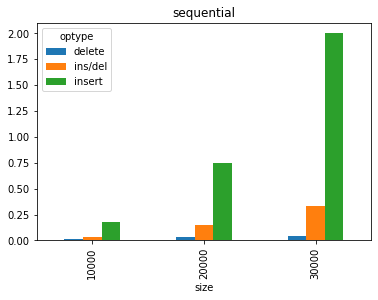

In [54]:
# Sequential https://towardsdatascience.com/reshaping-a-dataframe-with-pandas-stack-and-unstack-925dc9ce1289
# https://stackoverflow.com/questions/59204445/how-to-do-i-groupby-count-and-then-plot-a-bar-chart-in-pandas
df = dfs['sequential.csv']
df.pivot_table(index='size', values='time', columns='optype').plot(kind='bar', legend=True, title='sequential')

### Speedup Graphs

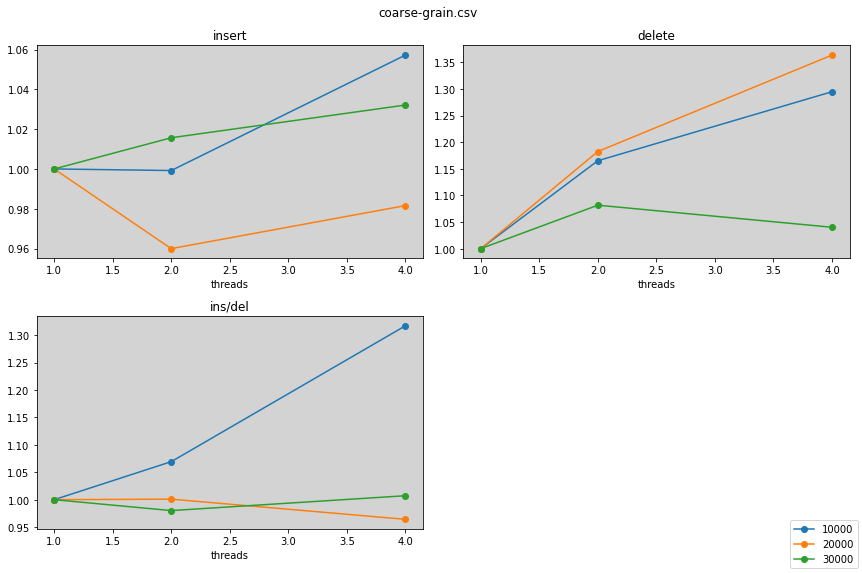

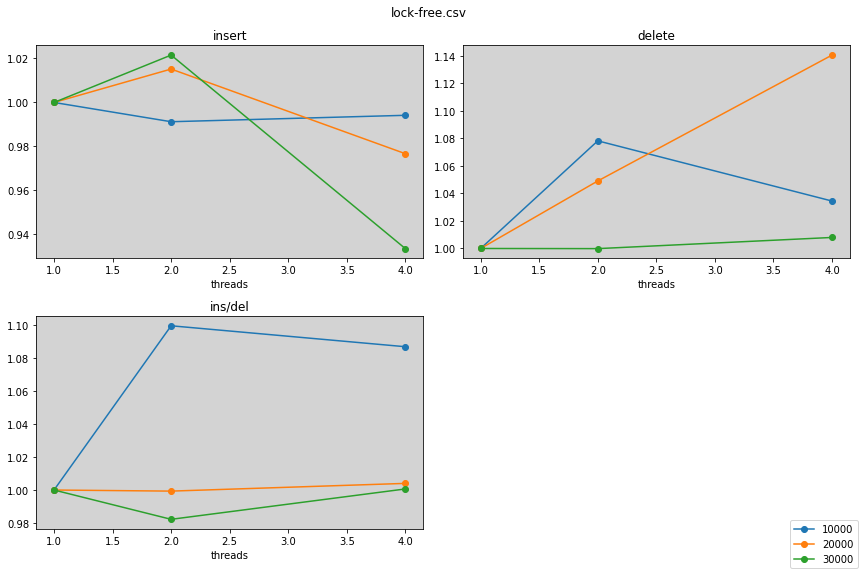

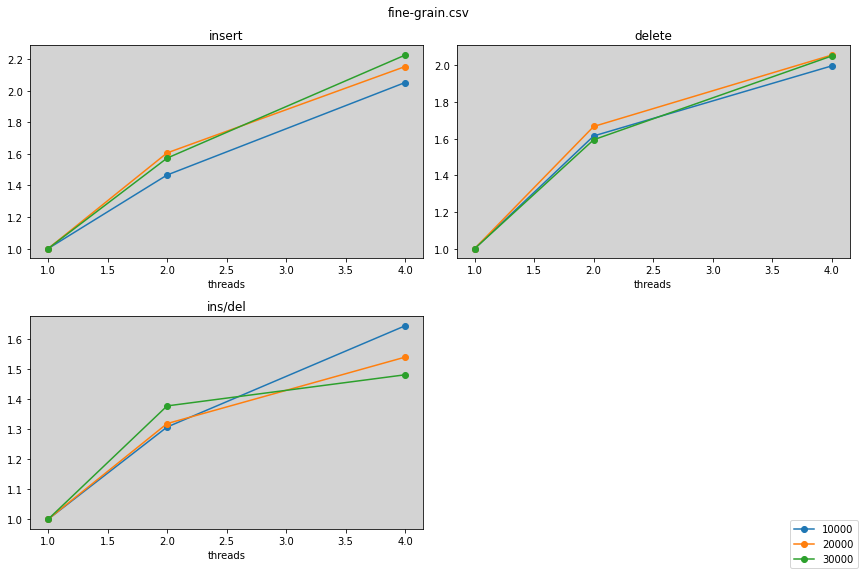

In [48]:
# https://stackoverflow.com/questions/41309467/matplotlib-plot-multiple-lines-per-time-series-subplot

optypes = ['insert', 'delete', 'ins/del']
for name, df in dfs.items():
    if name != 'sequential.csv':
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
        # create 2d -> 1d array
        axes = axes.ravel() 
        # remove last axes
        fig.delaxes(axes[-1])
        df = df.pivot_table(index='threads', values='time', columns=['optype', 'size'])
        # print(df)
        for i, optype in enumerate(optypes): # colname = first column which is optype
            unnormalized_series = df[optype] # a series is one columns
            row1 = unnormalized_series.loc[1] # thread 1,2, or 4, series[10000] is column
            series = row1 / unnormalized_series
            series.plot(kind='line', legend=False, title=optype, ax=axes[i], marker='o')
            if i == 2:
                handles, labels = axes[i].get_legend_handles_labels()
                fig.legend(handles, labels, loc='lower right', prop={'size': 10})
            axes[i].set_facecolor('lightgray')

                # this makes lower right relative to the last axes
                # axes[i].legend(loc='lower right')
        
        # prevent overlapping subplots
        fig.suptitle(name)
        fig.tight_layout() 
        # fig.patch.set_facecolor('gray')

I leave much of the analysis and observations up to you. Some questions to get you thinking are:
1) What is the overall trend/performance
2) Compare across different operations, what makes some some operations witness better speedup than others
   1) Why do you think this is the case
   2) Use `perf` to to specific points (hint: checkout the other branches to find out I used perf. Malloc is an expensive operation)
   3) Is your hypothesis confirmed?
3) Try scaling this for more threads in the code
4) Which sizes have better speedup, and why do you think so?
5) Why do we not achieve perfect speedup?
6) Compare fine-grain against lock-free, which performed better and why?
7) Compare sequential against the concurrent versions. Did you get what you expected?